# Reports

In [1]:
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg', 'pdf']
# %config InlineBackend.rc = {'figure.dpi' : 96 }

In [2]:
from pathlib import Path

from harissa.benchmark import Benchmark
from harissa.plot import build_pos
from harissa.plot.plot_benchmark import plot_benchmark

import sys
sys.path.append('../examples')

In [3]:
archive = Path('../cardamom_benchmark')
benchmark = Benchmark(path=archive, verbose=True)
benchmark.networks.exclude = ['Trees*/*']

show_networks = True

## Default reports

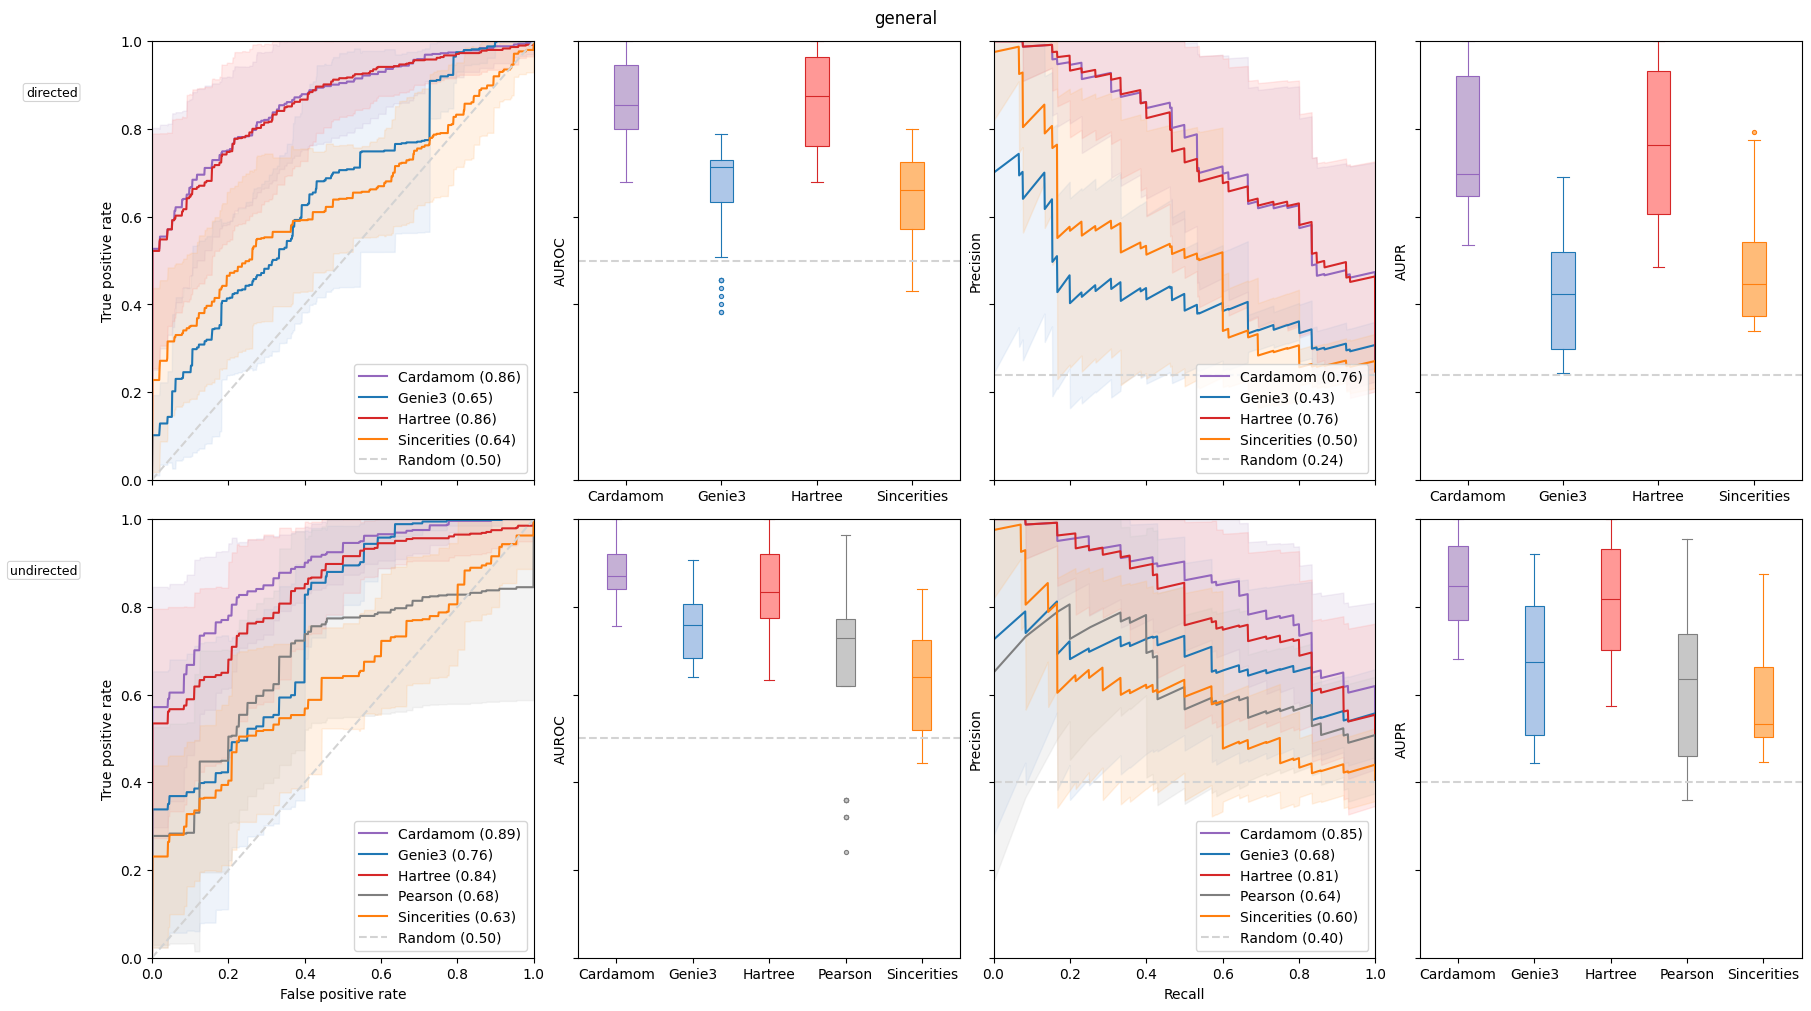

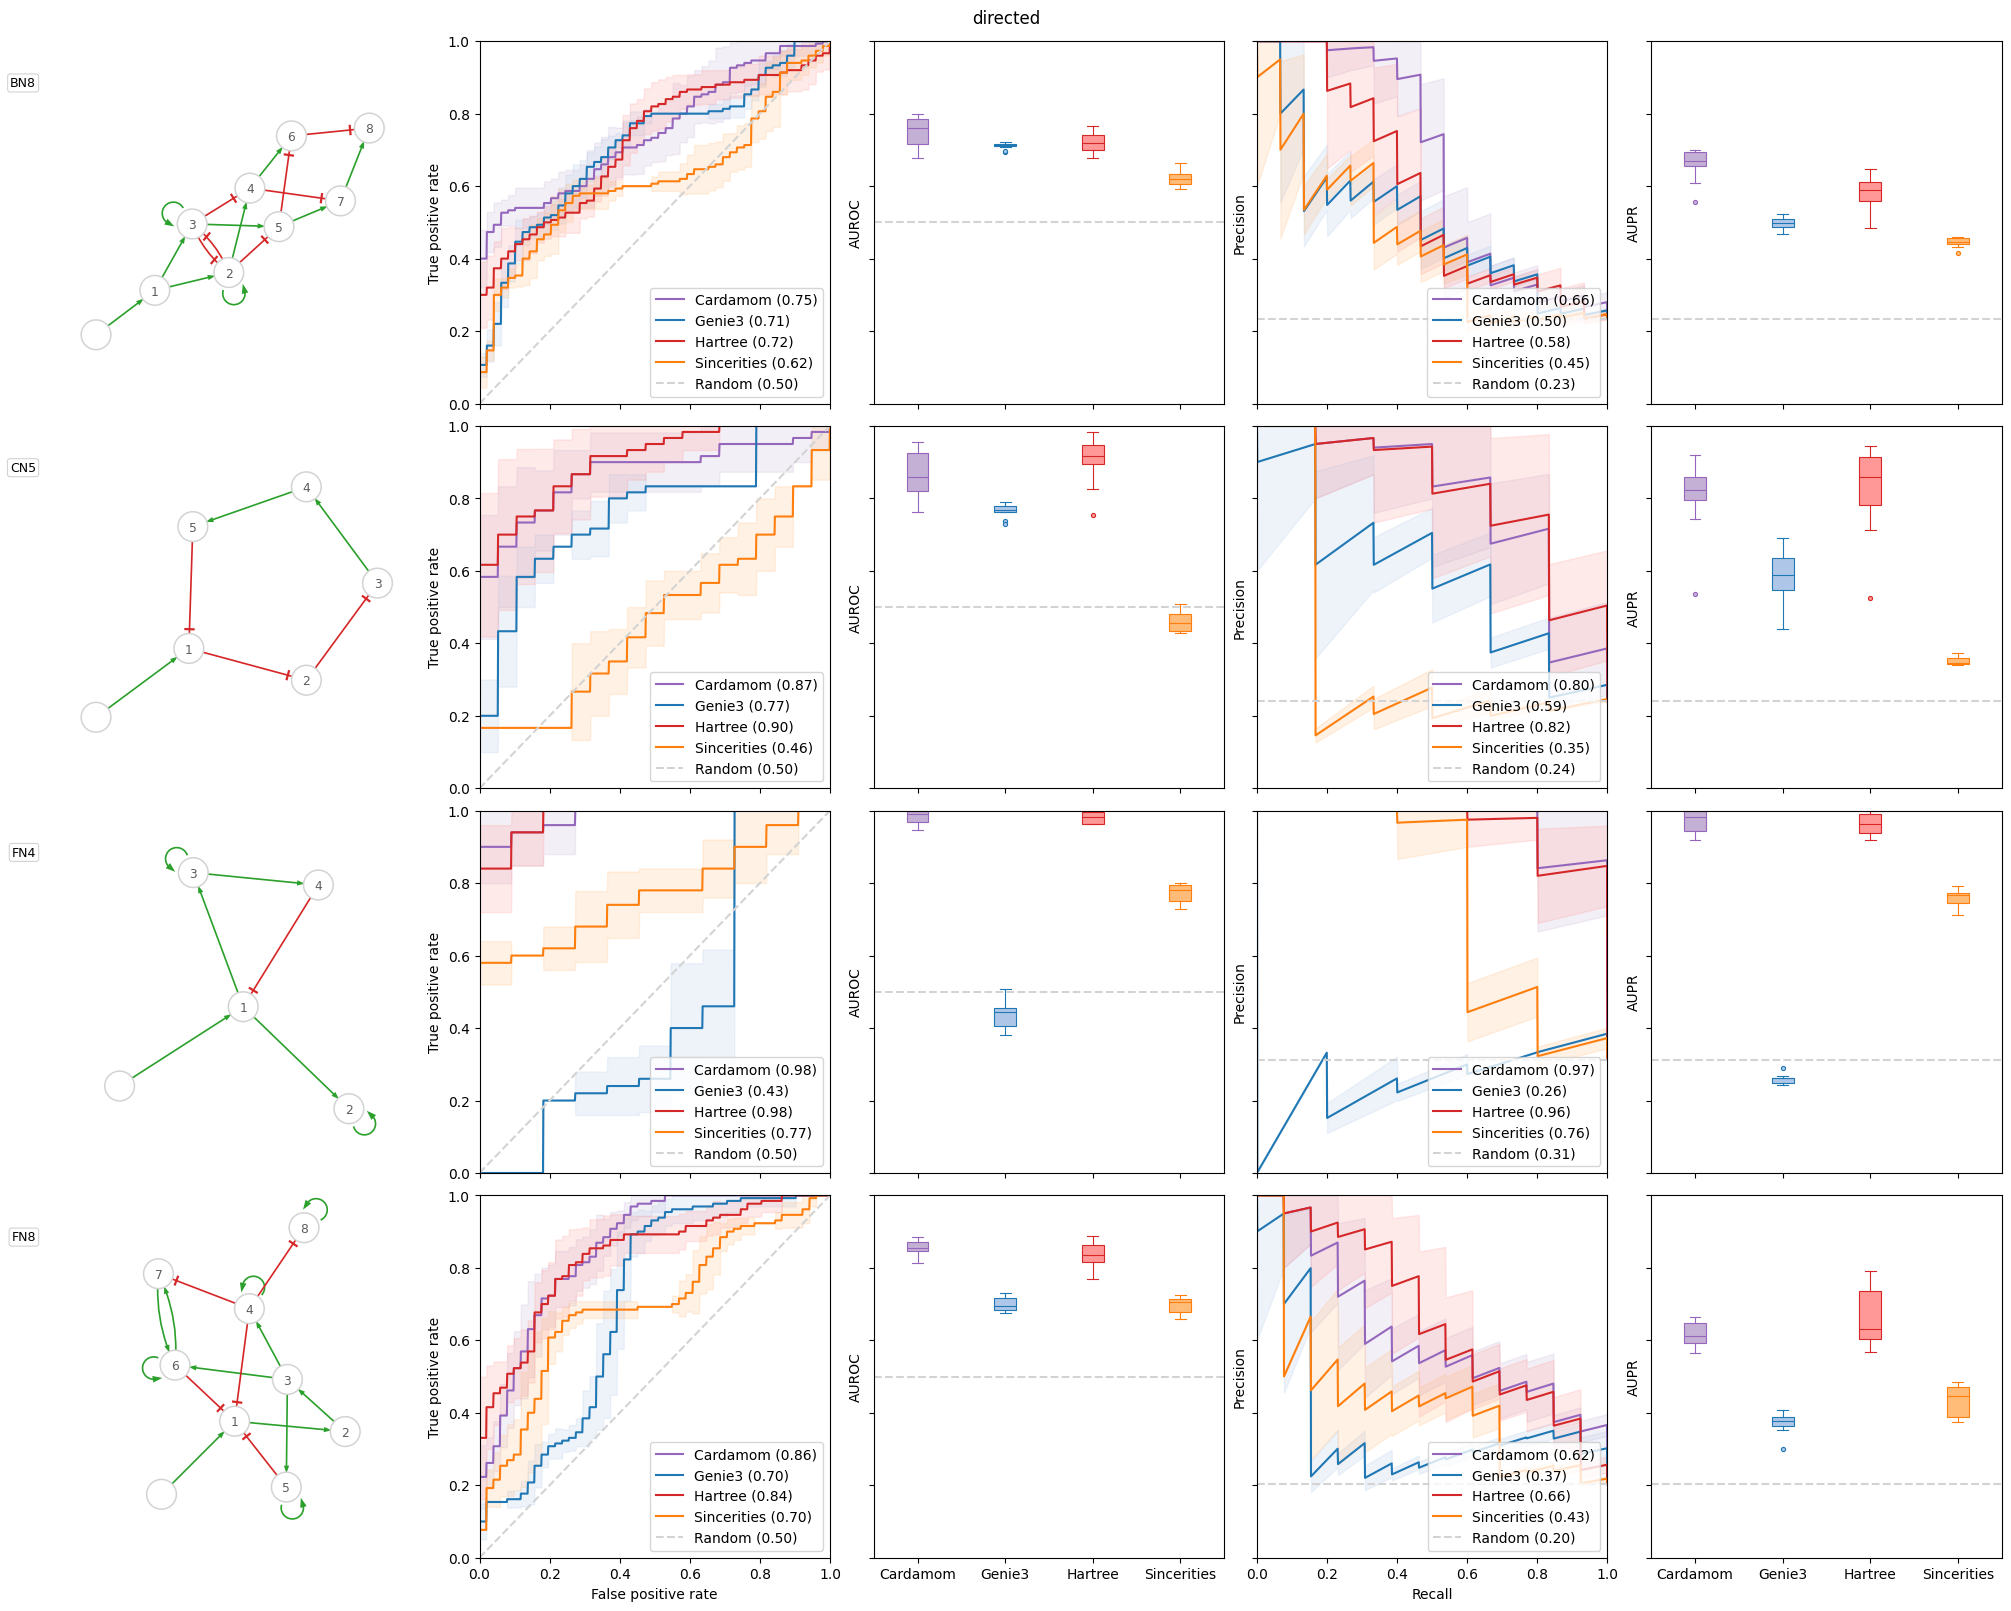

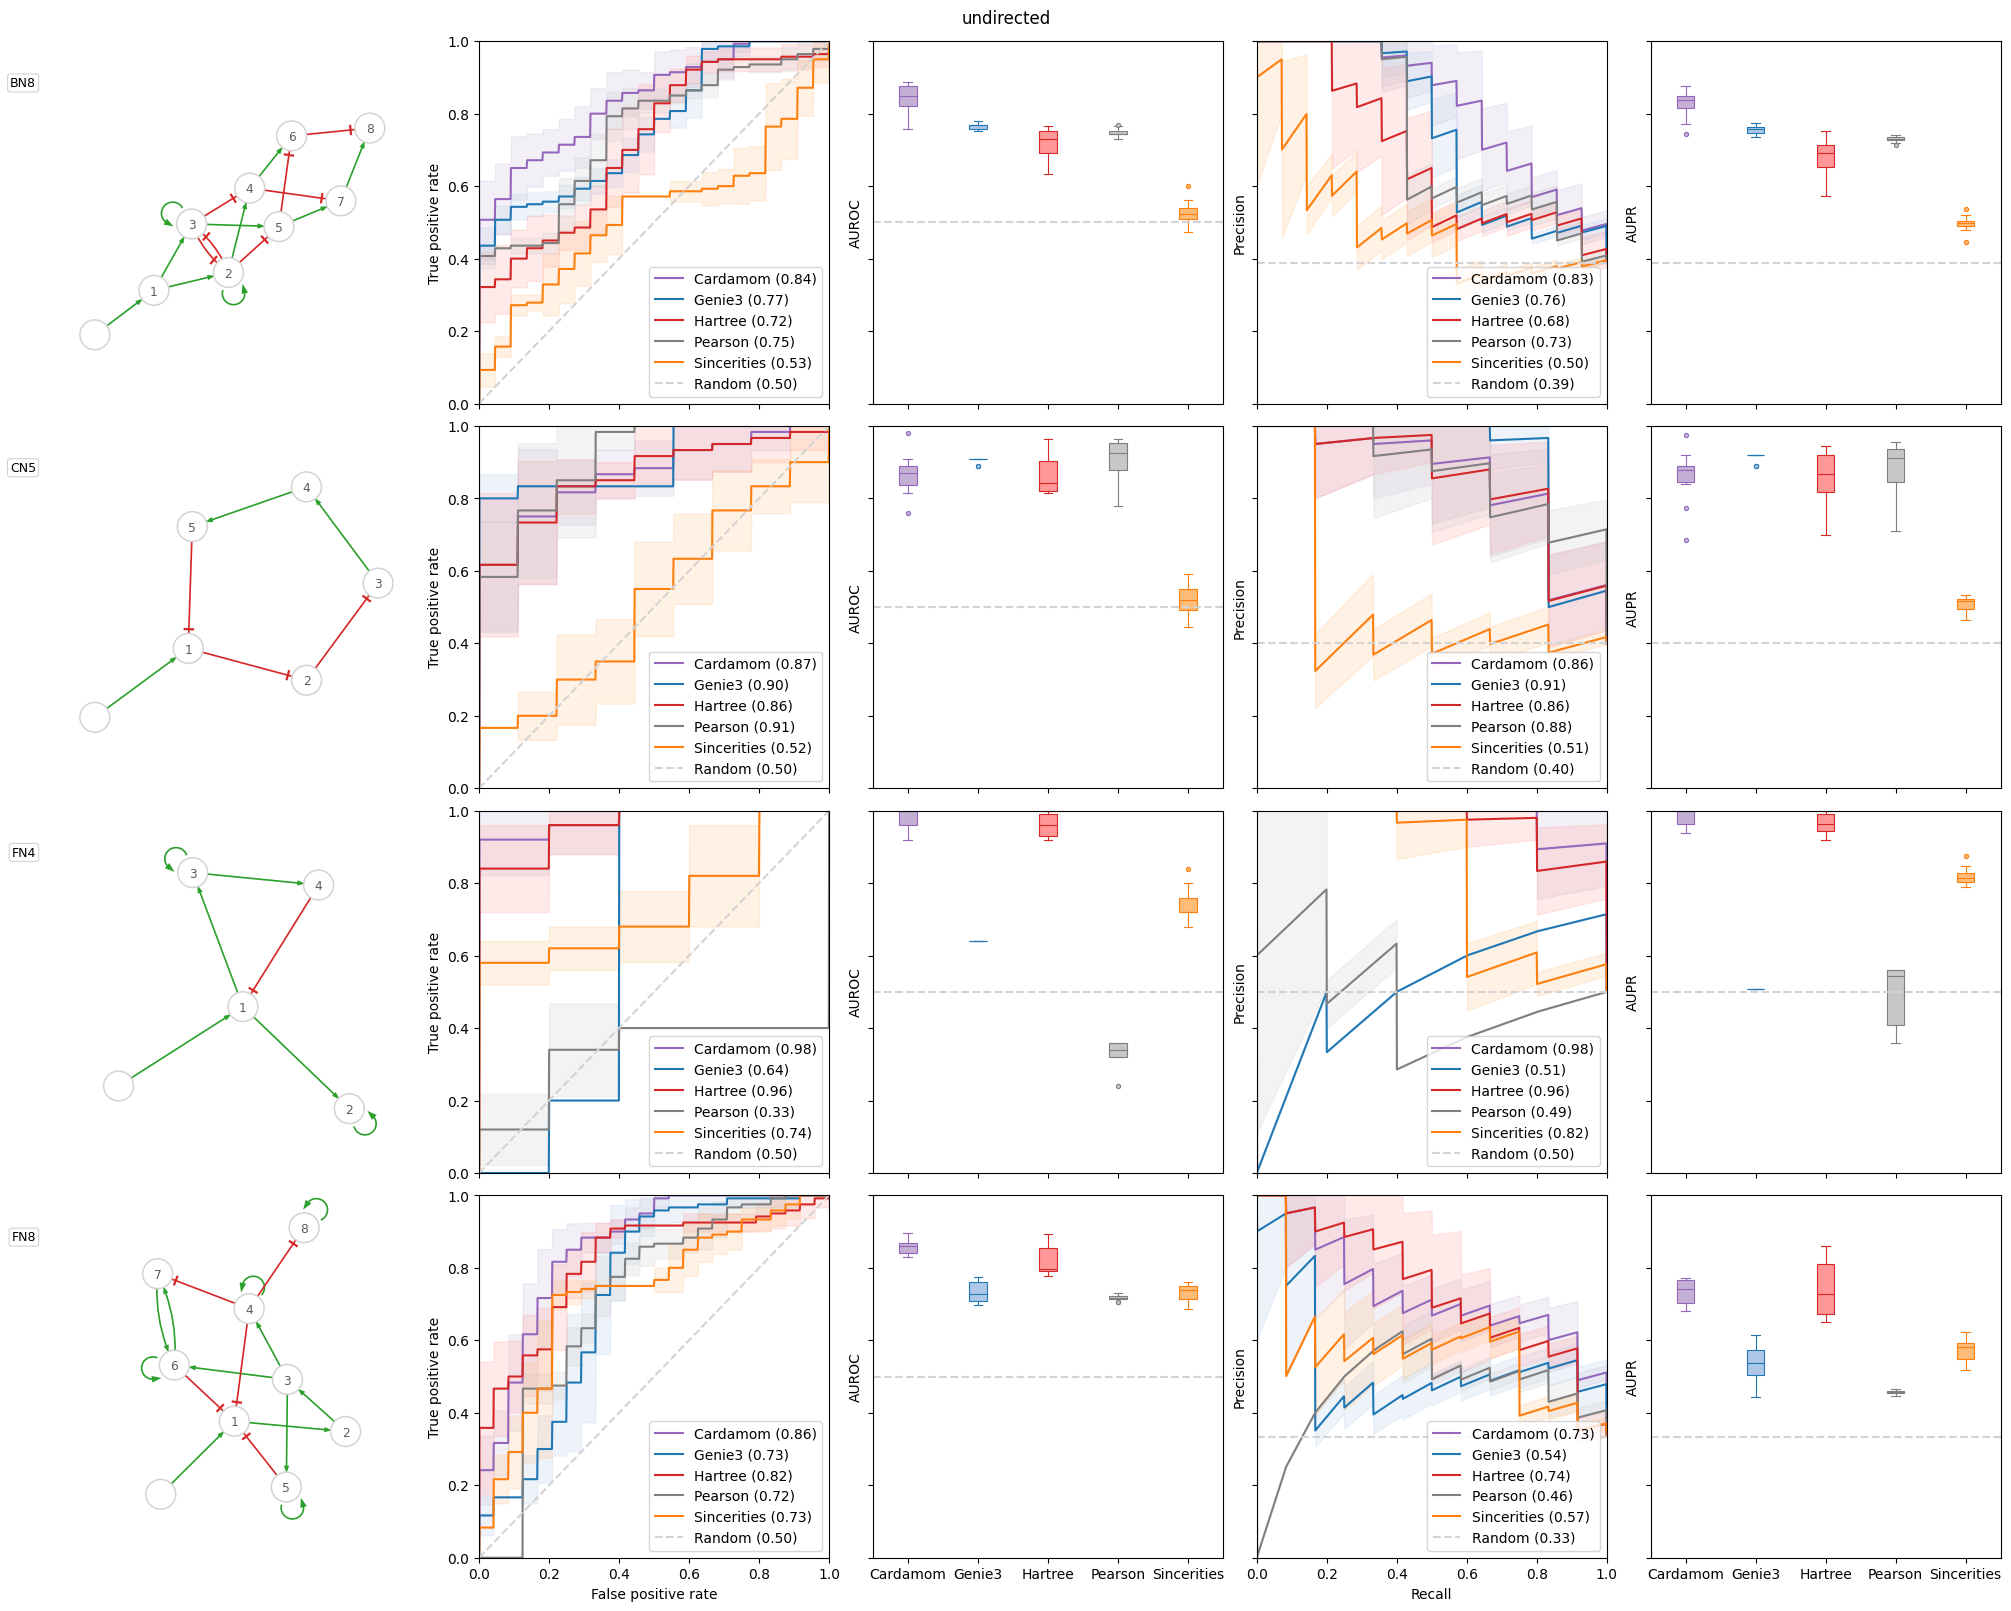

In [4]:
figs = benchmark.reports(show_networks)

## Custom Reports

### First example: reordering

By default networks, inference methods are sorted by lexicographic order.
If you want to use an other order use the function `plot_benchmark` and give it
your orders

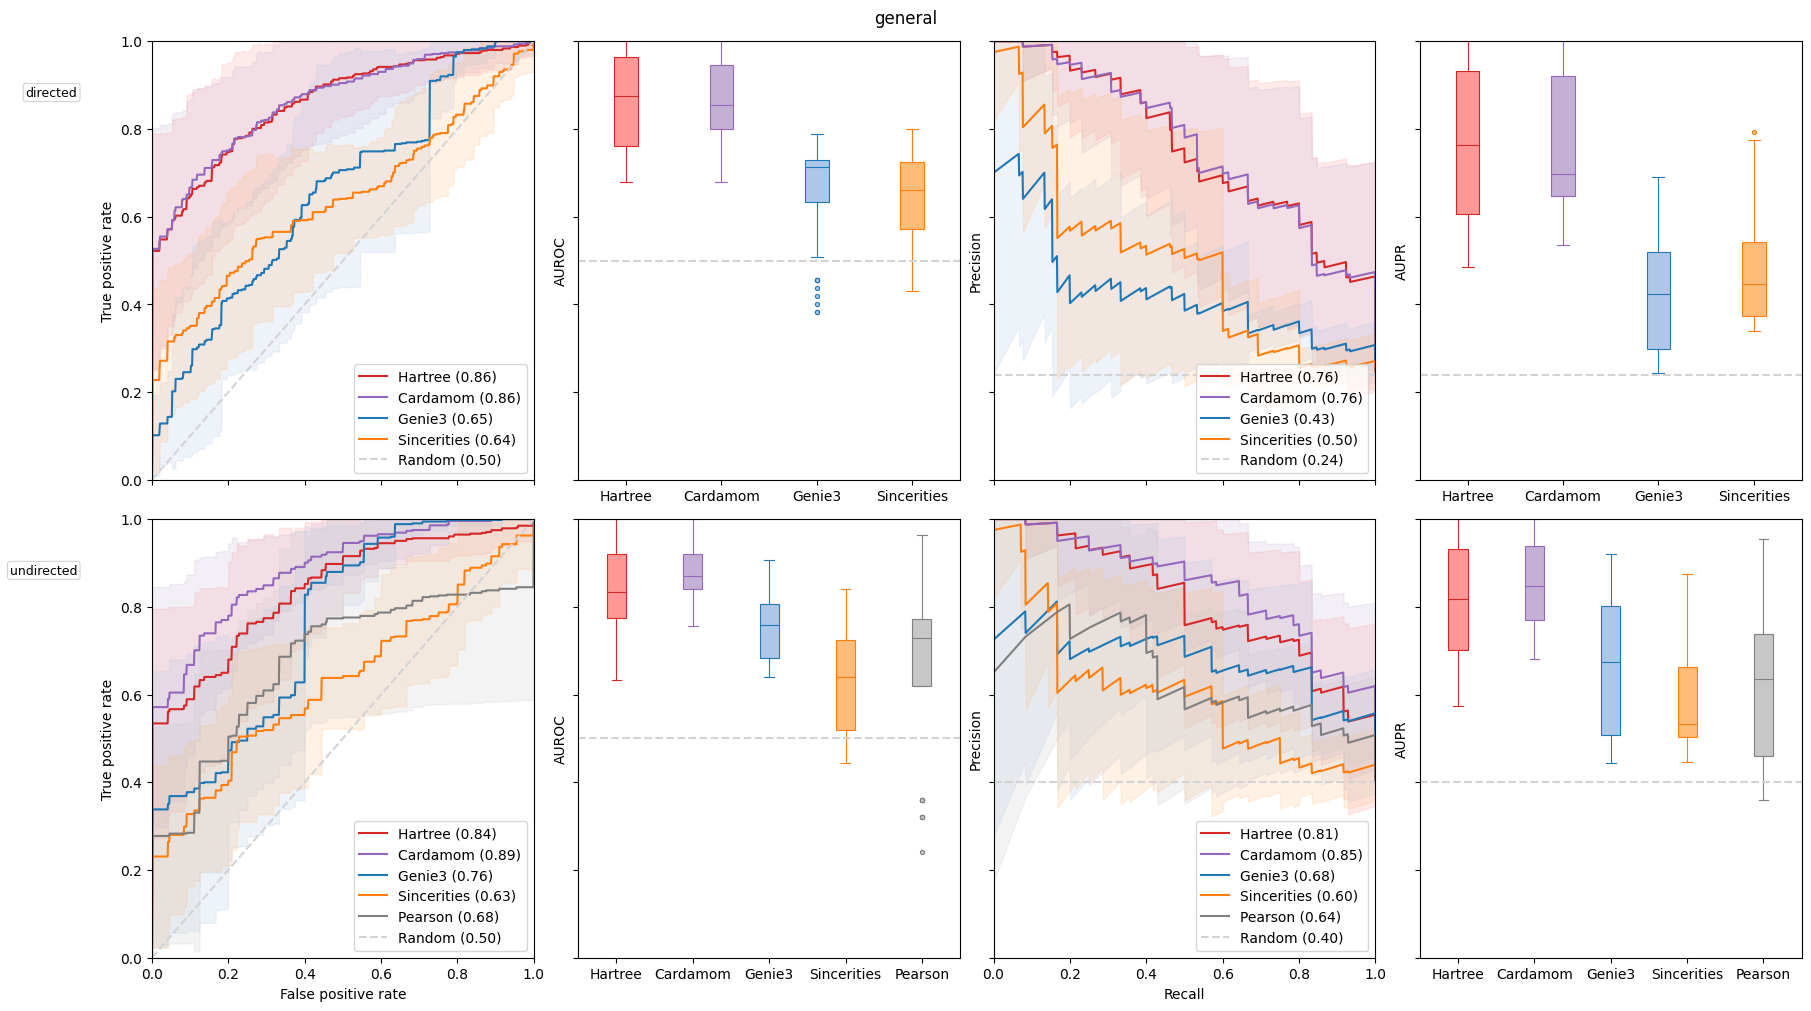

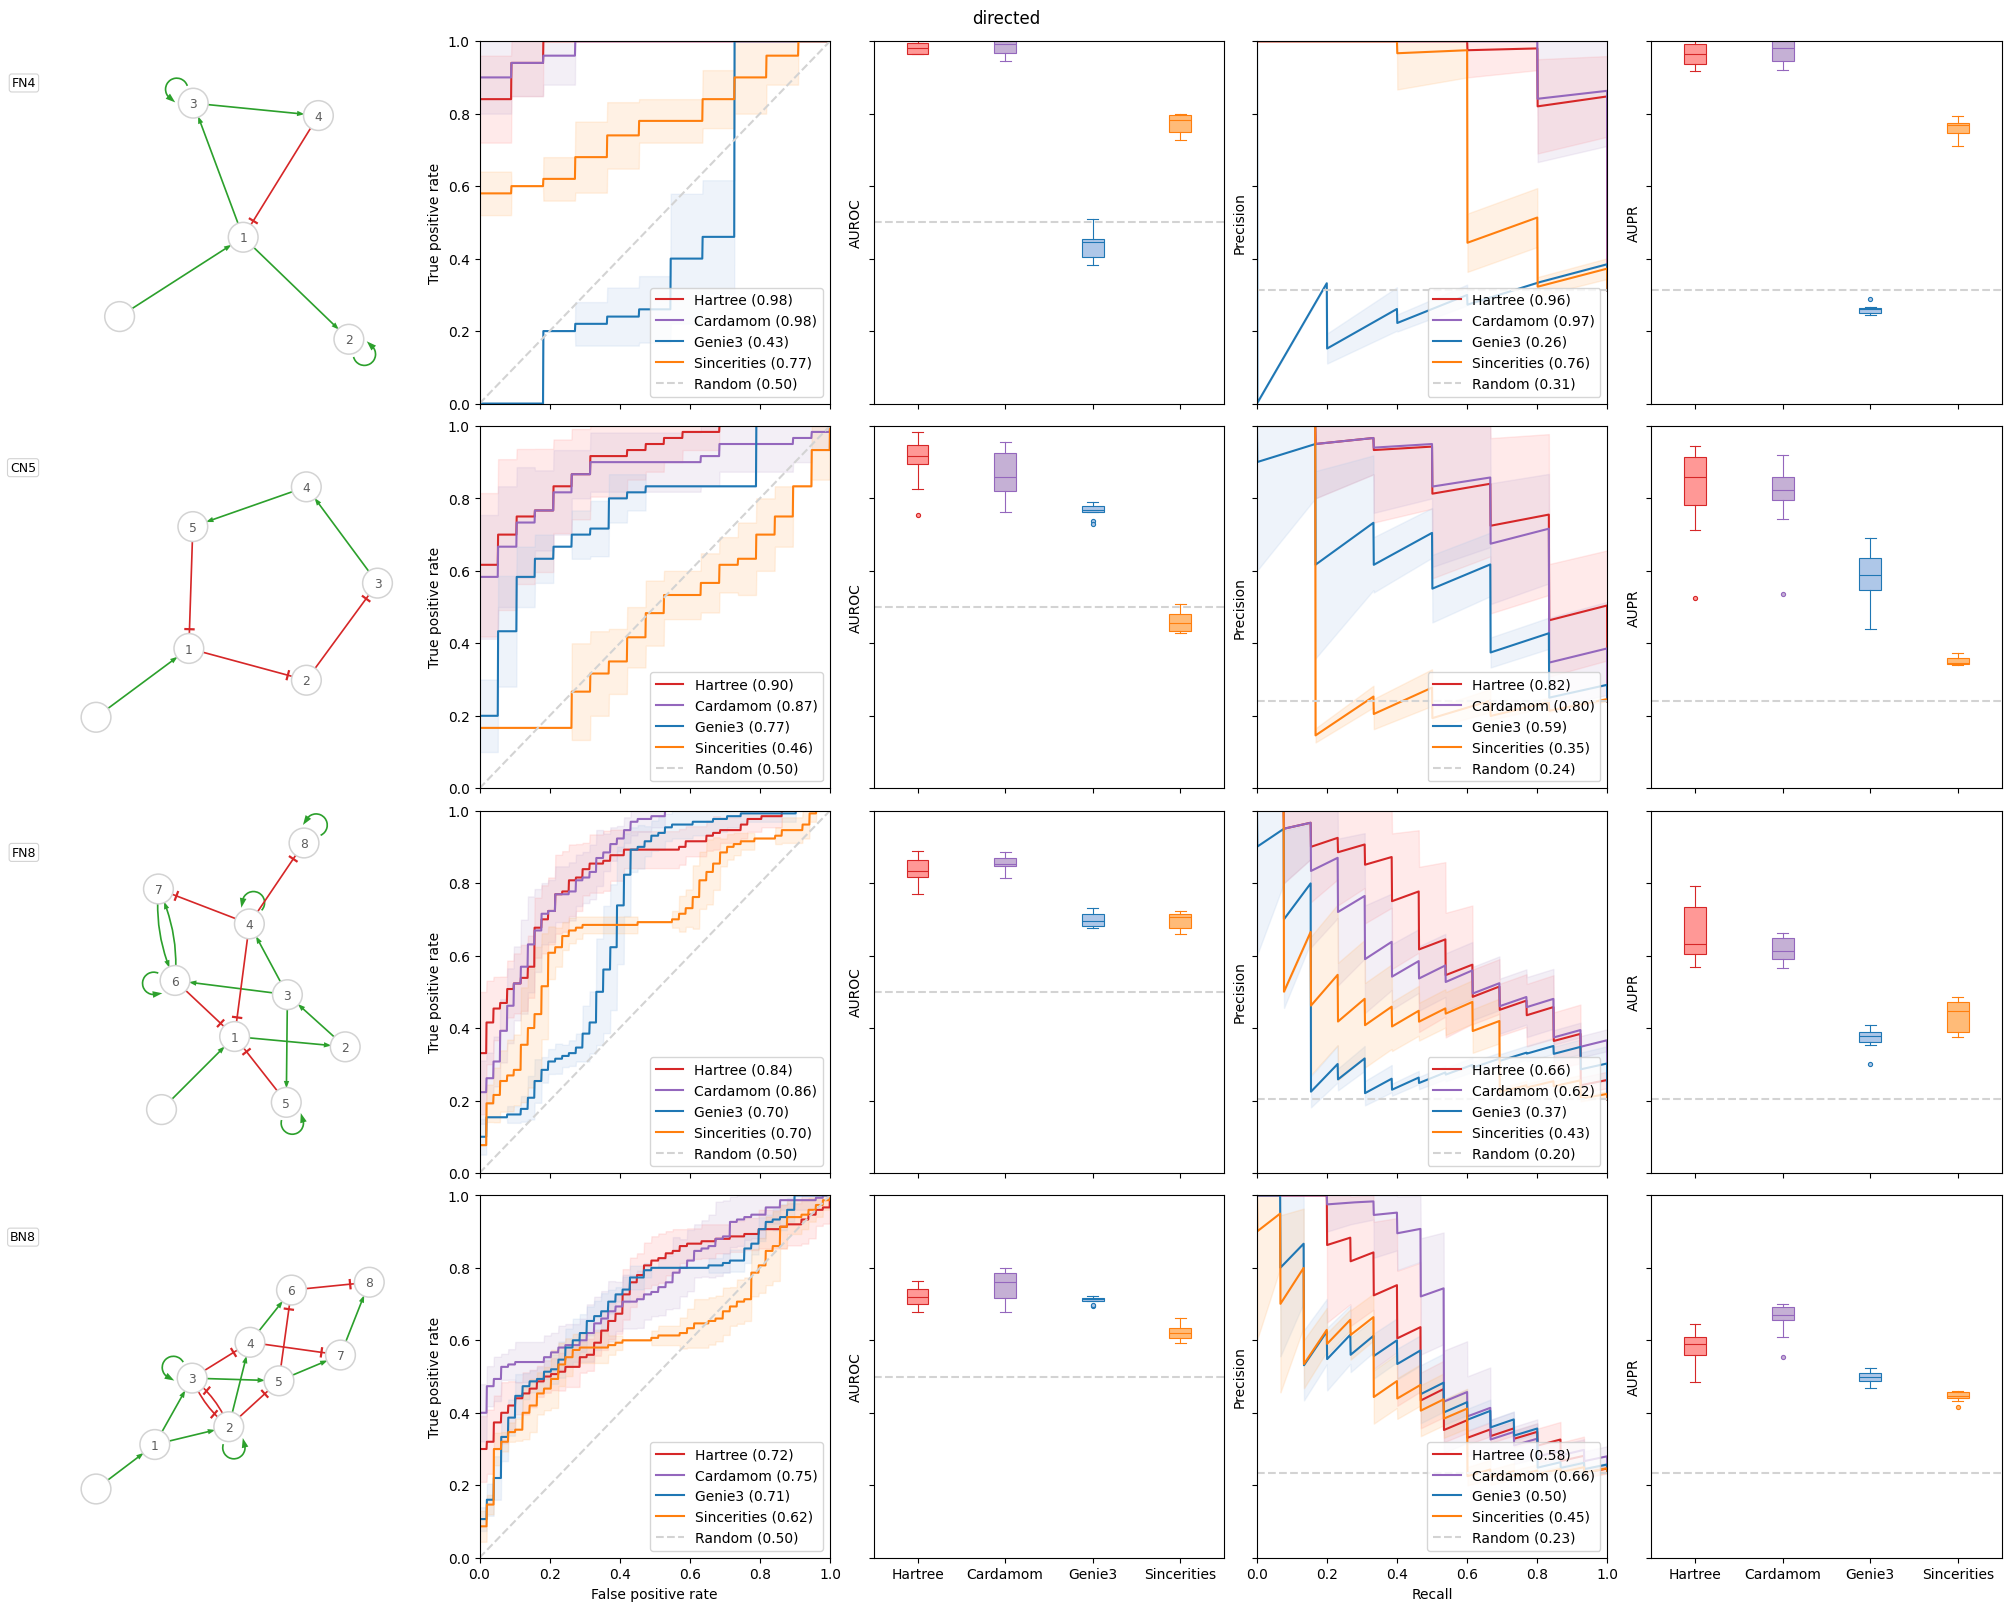

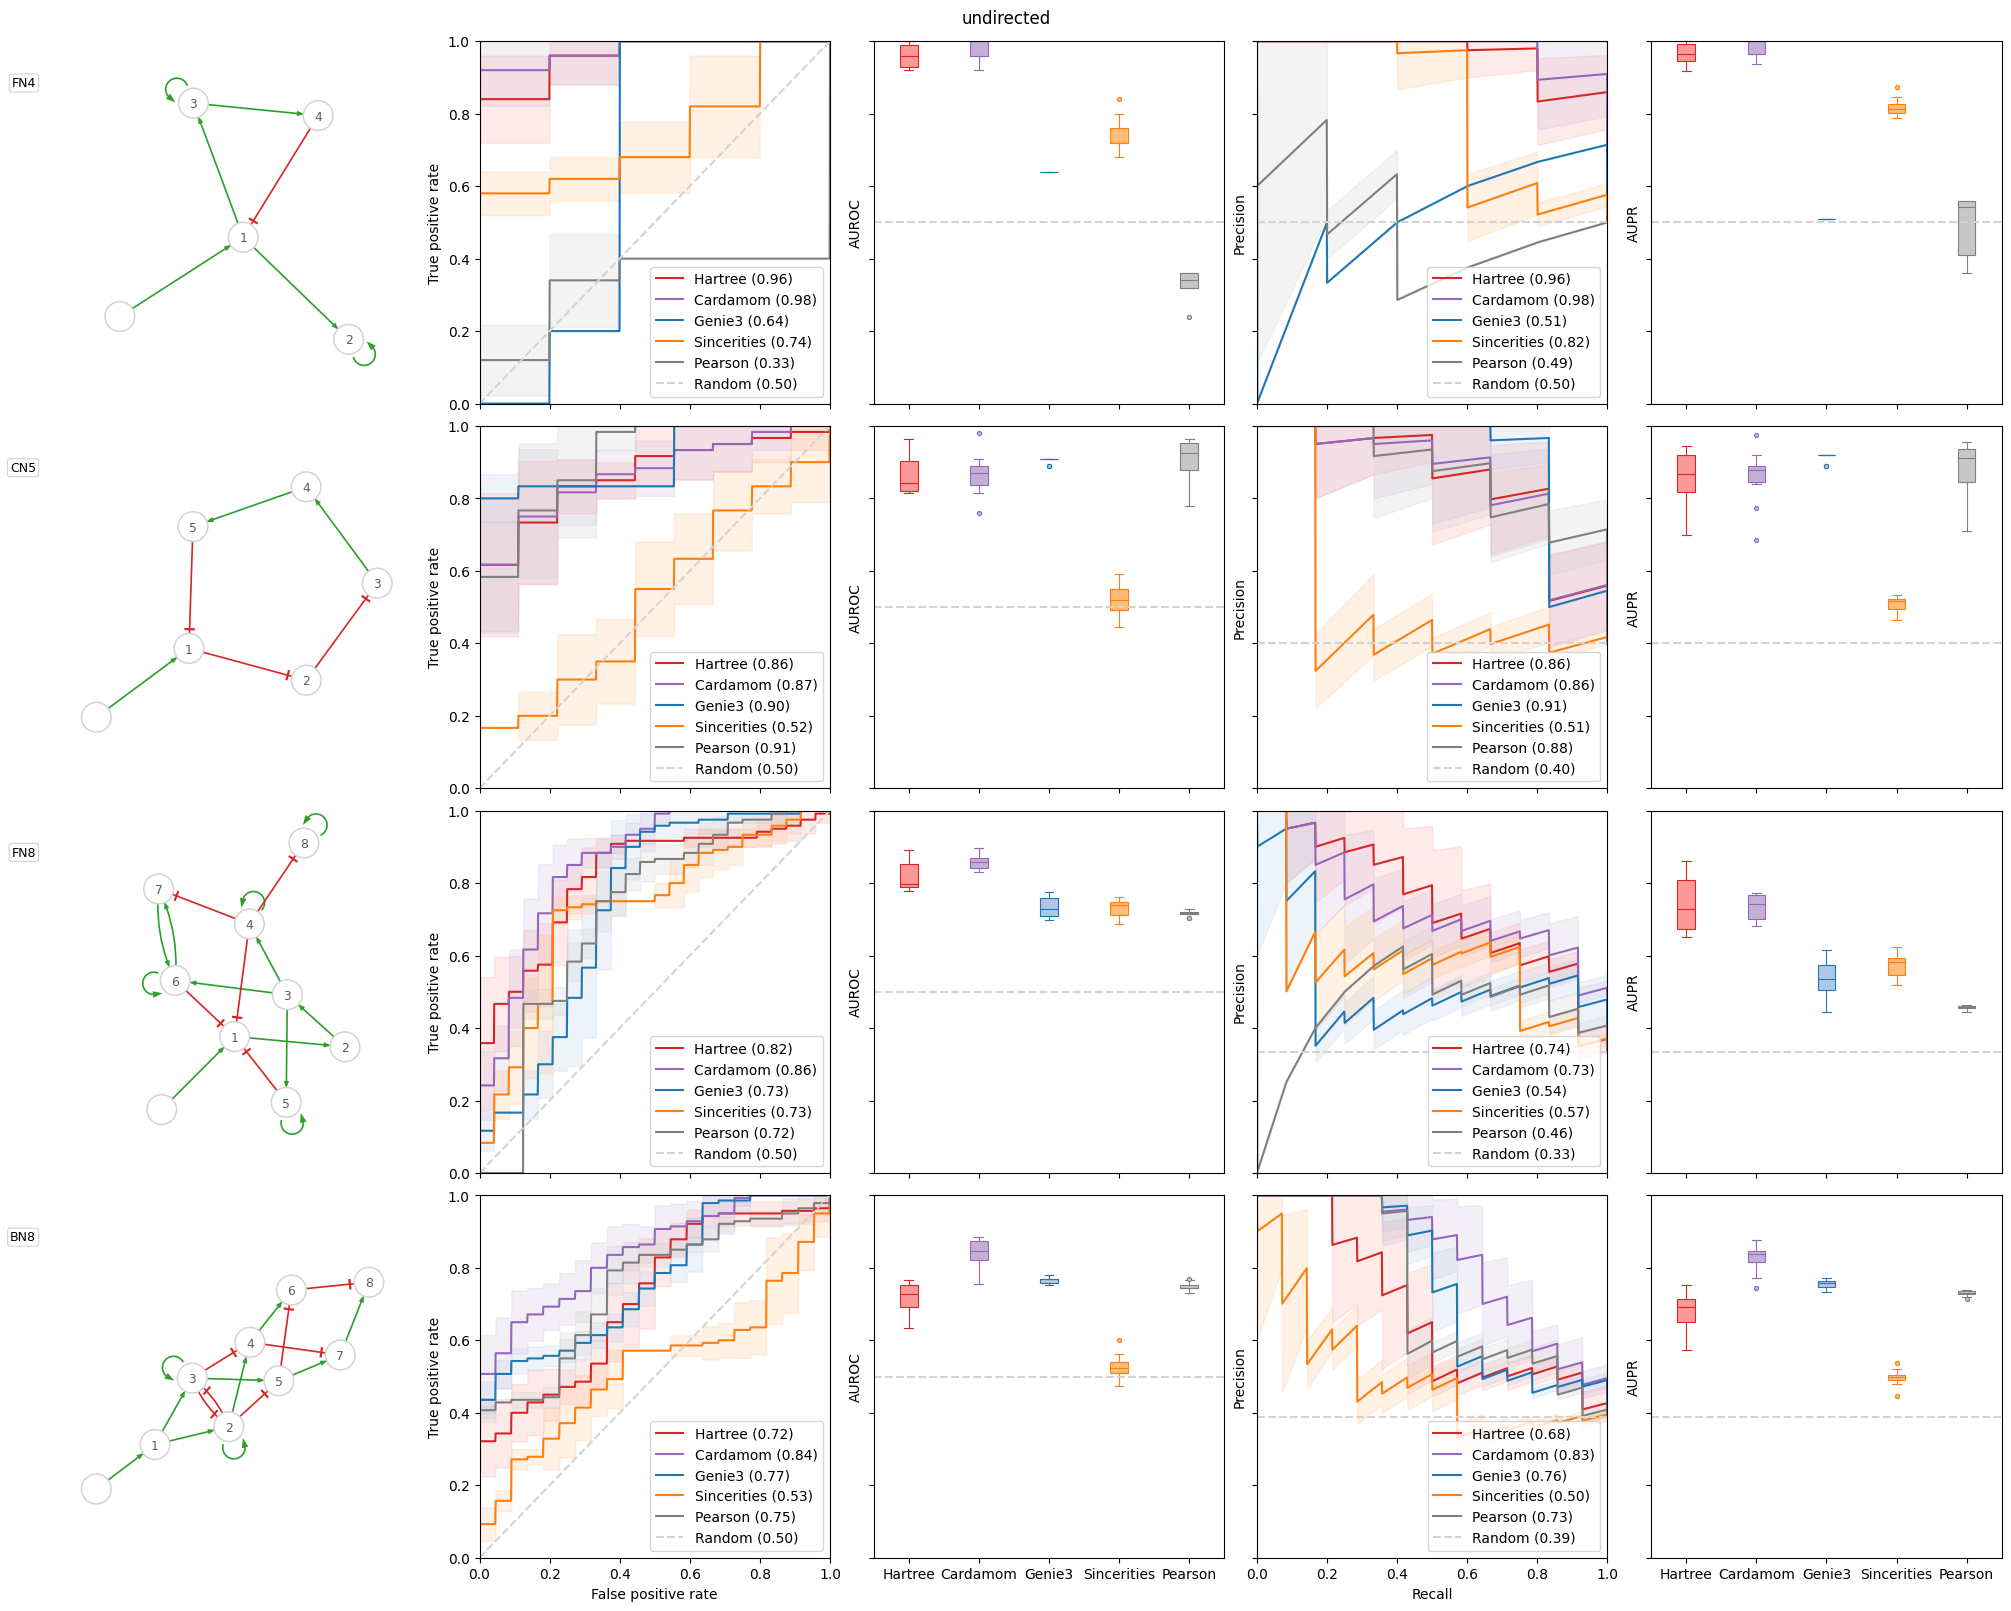

In [5]:
networks_order = [
    'FN4',
    'CN5',
    'FN8',
    'BN8'
]

inferences_order = [
    'Hartree', 
    'Cardamom',
    'Genie3', 
    'Sincerities', 
    'Pearson',
]


figs = plot_benchmark(
    benchmark, 
    networks_order, 
    inferences_order, 
    show_networks
)

### Second example

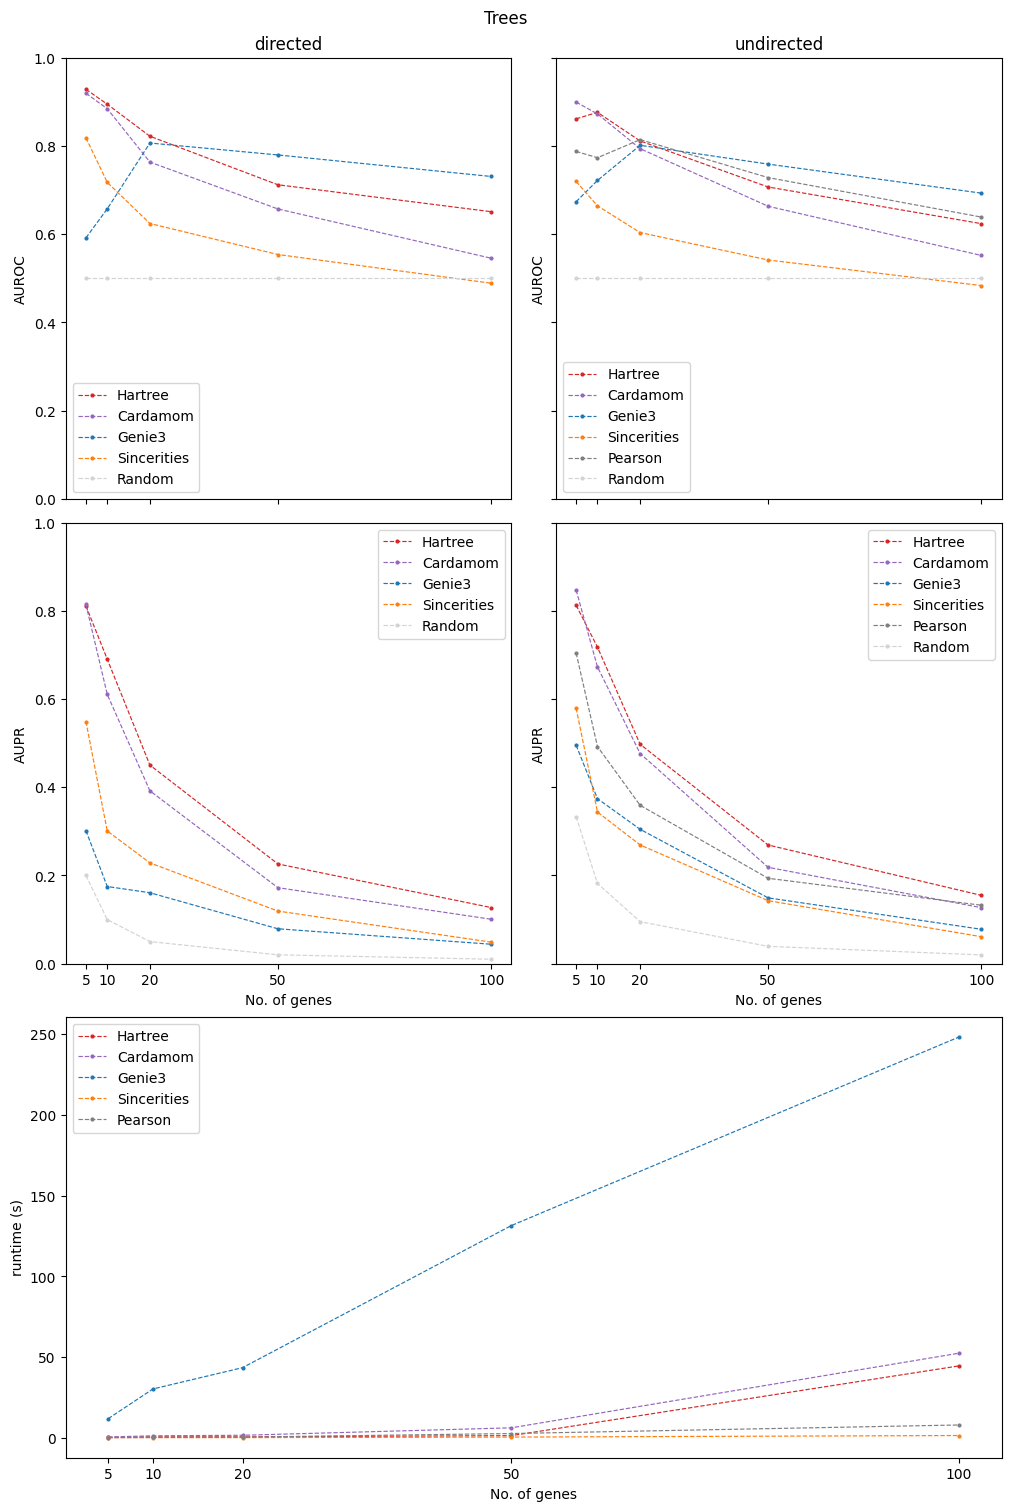

In [20]:
import numpy as np
from harissa.plot.plot_benchmark import DirectedPlotter, UnDirectedPlotter
import matplotlib.pyplot as plt

n_genes = np.array([5, 10, 20, 50, 100])

benchmark.networks.include = [f'Trees{g}/*' for g in n_genes]
benchmark.networks.exclude = []

plotters = [DirectedPlotter(), UnDirectedPlotter()]

inferences_stats = {
    inf:[None, {g:[] for g in n_genes}] for inf in inferences_order 
}

fig = plt.figure(figsize=(10, 15), layout='constrained')
fig.suptitle('Trees')
axs = [fig.add_subplot(3, 2, k) for k in range(1, 5)]
axs.append(fig.add_subplot(3, 2, (5, 6)))

for key, (network, (inf, colors), _, result, runtime) in benchmark.items():
    score = result.parameter.interaction
    for plotter in plotters:
        plotter.network = network
    auc = [
        *[
            plotter.auroc(score) 
            for plotter in plotters if plotter.accept_inference(inf)
        ],
        *[
            plotter.aupr(score) 
            for plotter in plotters if plotter.accept_inference(inf)
        ]
    ]
    inferences_stats[key[1]][0] = colors
    inferences_stats[key[1]][1][network.n_genes].append([*auc, runtime])

line_style= {'ls': '--', 'lw': 0.85, 'marker': '.', 'ms': 4}
for inf, (colors, stats_per_n_genes) in inferences_stats.items():
    nb_stats = len(stats_per_n_genes[n_genes[0]][0])
    y = np.zeros((n_genes.size, nb_stats))
    color = colors[0]
    for i, stats in enumerate(stats_per_n_genes.values()): 
        y[i] = np.mean(np.array(stats), axis=0)

    if nb_stats == len(axs):
        for j in range(nb_stats):
            axs[j].plot(n_genes, y[:, j], color=color, label=inf, **line_style)
    else:
        axs[1].plot(n_genes, y[:, 0], color=color, label=inf, **line_style)
        axs[3].plot(n_genes, y[:, 1], color=color, label=inf, **line_style)
        axs[4].plot(n_genes, y[:, 2], color=color, label=inf, **line_style)

for i in range(2):
    ax = axs[i]
    ax.plot(
        n_genes, 
        np.full(n_genes.size, 0.5), 
        color='lightgray', 
        label='Random', 
        **line_style
    )
    if i % 2 == 0:
        ax.set_title('directed')
        ax.set_ylim(0.0, 1.0)
    else:
        ax.set_title('undirected')
        ax.sharey(axs[0])
        plt.setp(ax.get_yticklabels(), visible=False)

    ax.set_ylabel('AUROC')
    plt.setp(ax.get_xticklabels(), visible=False)


for i in range(2, 4):
    ax = axs[i]
    y = np.zeros(n_genes.size)
    plotter = plotters[i - 2]
    for j, g in enumerate(n_genes):
        plotter.network = benchmark.networks[f'Trees{g}/1']
        y[j] = np.mean(plotter.truth)

    ax.plot(n_genes, y, color='lightgray', label='Random', **line_style)
    if i % 2 == 0:
        ax.set_ylim(0.0, 1.0)
    else:
        ax.sharey(axs[2])
        plt.setp(ax.get_yticklabels(), visible=False)

    ax.set_xlabel('No. of genes')
    ax.set_ylabel('AUPR')

axs[-1].set_ylabel('runtime (s)')
axs[-1].set_xlabel('No. of genes')


for ax in axs:
    ax.set_xticks(n_genes)
    ax.legend(loc='best')

